In [1]:
import numpy as np
import pandas as pd 
import obspy
import creep_event_picker as cep
import datetime as dt
import matplotlib.pyplot as plt
import inflect
stringify = inflect.engine()
import math
import os
import raw_to_obspy as rto
from os import listdir
from os.path import isfile, join
import importlib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
network = 'Central_San_Andreas_Fault'
#station = ['crr','cwc3','cwn','tabc','wkr','x46','xgh','xhr','xhr1','xhr2','xhsw','xmbc','xmd','xmm','xmr','xpk','xpk1','xrsw','xsc','xsj','xsj2','xta','xva']
station = ['xmro']
#station = ['Gok','Has','Hat','Kar','Kir','Orm','pan','pas','Tas']
path = "../../Data/{p}/SAC".format(p=network)
rto.check_dir(path)
#Creepmeter_dataframe = pd.DataFrame(columns = ['Network','Creepmeter','Start Time','End Time','Sampling rate, Hz','Sampling rate, mins','Latitude','Longitude'])
#Creepmeter_dataframe.to_csv('../../../Data/creepmeter_lookup.csv')
Creepmeter_dataframe = pd.read_csv('../../Data/creepmeter_lookup.csv',index_col=0)

Import data and create .SAC files for USGS creepmeters

xmro
warning, sample rate may have changed, consider splitting


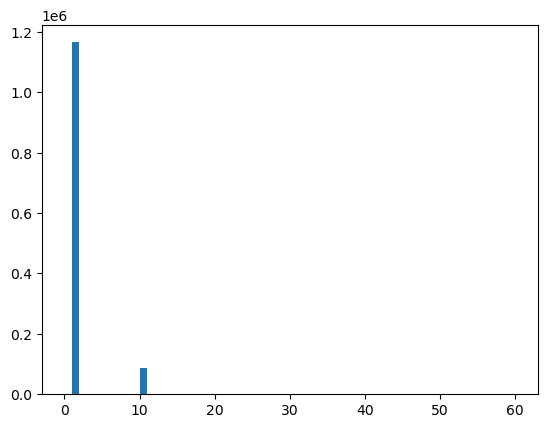

[1]
[1] ['C']
interpolating creeping_C
1


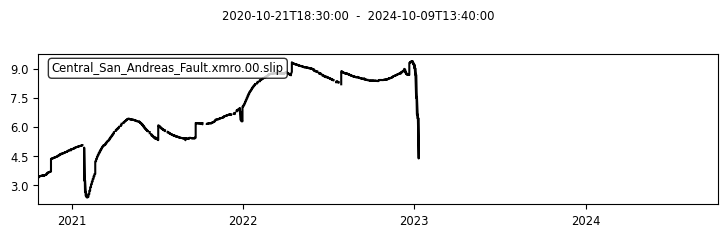

No A
No B
                       Network                 Creepmeter_full_name  \
0              Calaveras_Fault                          Shore Rd #1   
1                Hayward_Fault                       Fremont Winery   
2                Hayward_Fault                       Fremont Winery   
3                Hayward_Fault                       Fremont Winery   
4                Hayward_Fault              Hayward Palisades St #2   
5                Hayward_Fault              Hayward Palisades St #3   
6                Hayward_Fault                          Oakland Zoo   
7                Hayward_Fault                          Oakland Zoo   
8                Hayward_Fault                          Oakland Zoo   
9                Hayward_Fault                            Pt Pinole   
10               Hayward_Fault                            Pt Pinole   
11               Hayward_Fault                             Temescal   
12               Hayward_Fault                             Temescal

In [13]:
importlib.reload(rto)
importlib.reload(cep)
for j in range(len(station)):
    creeping, tm_diff = rto.import_USGS(station[j],network)
    #creeping, tm_diff = rto.import_USGS_C46(station[j],network)

    plt.figure()
    bins = np.arange(0,61,1)
    plt.hist(tm_diff,bins=bins)
    plt.show()


    bins_hist, hist_val = np.histogram(tm_diff,bins)
    boolarr = bins_hist > 150000
    periods = hist_val[1:][boolarr] -1
    print(periods)

    if len(periods) >= 2:
        print('warning, this needs thinking about majorly!')

        a = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[0]), g = stringify.number_to_words(periods[1])))
        b = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[1]), g = stringify.number_to_words(periods[0])))

        creeping_A = creeping.iloc[:a]
        creeping_B = creeping.iloc[a:b]
        creeping_C = creeping.iloc[b:]
    elif len(periods) == 1: 
        creeping_C = creeping.iloc[0:]
    

    Number_of_splits = []
    Sampling_rates_variable = []
    try:
        sampling_A = round((creeping_A.Tm.iloc[2] - creeping_A.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_A)
        Number_of_splits.append('A')
    except (IndexError, NameError):
        sampling_A = 0

    try:
        sampling_B = round((creeping_B.Tm.iloc[2] - creeping_B.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_B)
        Number_of_splits.append('B')
    except (IndexError, NameError):
        sampling_B = 0

    try:
        sampling_C = round((creeping_C.Tm.iloc[2] - creeping_C.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_C)
        Number_of_splits.append('C')
    except (IndexError, NameError):
        sampling_C = 0

    print(Sampling_rates_variable,Number_of_splits)
    #print(creeping_A,creeping_B,creeping_C)


    for i in range(len(Number_of_splits)):
        print('interpolating creeping_{k}'.format(k=Number_of_splits[i]))
        upsampled = rto.interpolate(eval('creeping_{k}'.format(k=Number_of_splits[i])),Sampling_rates_variable[i])
        val1_okay = math.isnan(upsampled.Creep.iloc[0])
        if val1_okay == True:
            upsampled.reset_index(inplace=True)
            upsampled.drop([0],axis=0,inplace=True)
        tr = obspy.Trace(np.array(upsampled.Creep))
        st = obspy.Stream(tr)
        st[0].stats.network = network
        st[0].stats.station = station[j]
        st[0].stats.location = '00'
        st[0].stats.channel = 'slip'
        st[0].stats.starttime = upsampled.Tm.iloc[0]
        st[0].stats.delta = 60*Sampling_rates_variable[i]
        st[0].plot()
        instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_full_name':'please fill','Creepmeter_abbrv':'please fill','File_code':['{p}_{q}'.format(p=station[j],q=i)],'Start Time':[st[0].stats.starttime],\
                                   'End Time':[st[0].stats.endtime],'Sampling rate, Hz':[st[0].stats.sampling_rate],\
                                    'Sampling rate, mins':(1/st[0].stats.sampling_rate)/60,'Latitude':['please fill'],'Longitude':['please fill']})
        
        Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument])
        st.write(path +'/{p}_{q}.SAC'.format(p=station[j],q=i),format='SAC')
    try:
        del(creeping_A)
    except NameError:
        print('No A')
    try:
        del(creeping_B)
    except NameError:
        print('No B')
    try: 
        del(creeping_C)
    except NameError:
        print('No C')
Creepmeter_dataframe.drop_duplicates('File_code',inplace=True)
Creepmeter_dataframe.reset_index(inplace=True)
Creepmeter_dataframe.drop(['index'], axis=1,inplace=True)
Creepmeter_dataframe.to_csv('../../../Data/creepmeter_lookup.csv')
print(Creepmeter_dataframe)

In [10]:
vls = np.loadtxt('../../Data/Central_San_Andreas_Fault/Raw/xmro.10min.gz', dtype = str)
vls[:,0]

array(['2020', '2020', '2020', ..., '2024', '2024', '2024'], dtype='<U13')

Import data and create .SAC files for Roger's creepmeters

In [ ]:
for j in range(len(station)):
    creeping, tm_diff = rto.import_csv_roger(station[j],network)

    plt.figure()
    bins = np.arange(0,61,1)
    plt.hist(tm_diff,bins=bins)
    plt.show()


    bins_hist, hist_val = np.histogram(tm_diff,bins)
    boolarr = bins_hist > 50000
    periods = hist_val[1:][boolarr] -1
    print(periods)

    if len(periods) >= 2:
        print('warning, this needs thinking about majorly!')

        a = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[0]), g = stringify.number_to_words(periods[1])))
        b = eval('rto.{k}_to_{g}(tm_diff)'.format(k = stringify.number_to_words(periods[1]), g = stringify.number_to_words(periods[0])))

        creeping_A = creeping.iloc[:a]
        creeping_B = creeping.iloc[a:b]
        creeping_C = creeping.iloc[b:]
    elif len(periods) == 1: 
        creeping_C = creeping.iloc[0:]
    

    Number_of_splits = []
    Sampling_rates_variable = []
    try:
        sampling_A = round((creeping_A.Tm.iloc[2] - creeping_A.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_A)
        Number_of_splits.append('A')
    except (IndexError, NameError):
        sampling_A = 0

    try:
        sampling_B = round((creeping_B.Tm.iloc[2] - creeping_B.Tm.iloc[1])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_B)
        Number_of_splits.append('B')
    except (IndexError, NameError):
        sampling_B = 0

    try:
        sampling_C = round((creeping_C.Tm.iloc[-1] - creeping_C.Tm.iloc[-2])/dt.timedelta(minutes=1))
        Sampling_rates_variable.append(sampling_C)
        Number_of_splits.append('C')
    except (IndexError, NameError):
        sampling_C = 0

    print(Sampling_rates_variable,Number_of_splits)
    print(creeping_C)
#

    for i in range(len(Number_of_splits)):
        print('interpolating creeping_{k}'.format(k=Number_of_splits[i]))
        upsampled = rto.interpolate(eval('creeping_{k}'.format(k=Number_of_splits[i])),Sampling_rates_variable[i])
        val1_okay = math.isnan(upsampled.Creep.iloc[0])
        if val1_okay == True:
            upsampled.reset_index(inplace=True)
            upsampled.drop([0],axis=0,inplace=True)
        tr = obspy.Trace(np.array(upsampled.Creep))
        st = obspy.Stream(tr)
        st[0].stats.network = network
        st[0].stats.station = station[j]
        st[0].stats.location = '00'
        st[0].stats.channel = 'slip'
        st[0].stats.starttime = pd.to_datetime(upsampled.Tm.iloc[0])
        st[0].stats.delta = 60*Sampling_rates_variable[i]
        #st[0].plot()
        instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_full_name':'please fill','Creepmeter_abbrv':'please fill','File_code':['{p}_{q}'.format(p=station[j],q=i)],'Start Time':[st[0].stats.starttime],\
                                   'End Time':[st[0].stats.endtime],'Sampling rate, Hz':[st[0].stats.sampling_rate],\
                                    'Sampling rate, mins':(1/st[0].stats.sampling_rate)/60,'Latitude':['please fill'],'Longitude':['please fill']})
        
        Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument])
        st.write(path +'/{p}_{q}.SAC'.format(p=station[j],q=i),format='SAC')
    try:
        del(creeping_A)
    except NameError:
        print('No A')
    try:
        del(creeping_B)
    except NameError:
        print('No B')
    try: 
        del(creeping_C)
    except NameError:
        print('No C')

#Creepmeter_dataframe.drop_duplicates('File_code',inplace=True)
Creepmeter_dataframe.reset_index(inplace=True)
Creepmeter_dataframe.drop(['index'], axis=1,inplace=True)
Creepmeter_dataframe.to_csv('../../../Data/creepmeter_lookup.csv')
print(Creepmeter_dataframe)

In [ ]:
creeping_C

Adding info to creepmeters database

In [ ]:
Creepmeter_dataframe = pd.read_csv('../../../Data/creepmeter_lookup.csv',index_col=0)
Creepmeter_dataframe